# Задание

[Датасет](/data/diabetes.csv) про диабет

1.  Загрузите выбранный датасет и выполните предварительную обработку данных.
2. Получите и визуализируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили).
3. Разделите данные на обучающий и тестовый наборы в соотношении, которое вы считаете подходящим.
4. Реализуйте логистическую регрессию "с нуля" без использования сторонних библиотек, кроме NumPy и Pandas. Ваша реализация логистической регрессии должна включать в себя:
  - Функцию для вычисления гипотезы (sigmoid function).
  - Функцию для вычисления функции потерь (log loss).
  - Метод обучения, который включает в себя градиентный спуск.
  - Возможность варьировать гиперпараметры, такие как коэффициент обучения (learning rate) и количество итераций.
5. Исследование гиперпараметров:
  - Проведите исследование влияния гиперпараметров на производительность модели. Варьируйте следующие гиперпараметры: 
    - Коэффициент обучения (learning rate).
    - Количество итераций обучения.
    - Метод оптимизации (например, градиентный спуск или оптимизация Ньютона).
6. Оценка модели:
- Для каждой комбинации гиперпараметров оцените производительность модели на тестовом наборе данных, используя метрики, такие как accuracy, precision, recall и F1-Score. Сделайте выводы о том, какие значения гиперпараметров наилучшим образом работают для данного набора данных и задачи классификации. Обратите внимание на изменение производительности модели при варьировании гиперпараметров.

# Решение
Импортируем необходимые библиотеки

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Предварительная обработка данных
### 1.1. Загрузка данных

In [31]:
file_path = './data/diabetes.csv'
data = pd.read_csv(file_path)

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.2. Обработка отсутствующих значений
Проверим наличие пропущенных значений в датасете и удалим строки с пропущенными значениями:

In [32]:
missing_values = data.isnull().sum()
print("Отсутствующие значения в каждой колонне:", missing_values, sep='\n')
rows_to_delete = data.isnull().any(axis=1).sum()
data = data.dropna()
print("Удалённые ряды:", rows_to_delete)

Отсутствующие значения в каждой колонне:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Удалённые ряды: 0


Удаляем строки с нулевыми значениями для столбцов Glucose, BloodPressure, SkinThickness, BMI 

In [33]:
labels_to_remove = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
zero_values = (data[labels_to_remove] == 0).sum()
print("Нулевые значения в каждой колонне:", zero_values, sep='\n')
rows_to_delete = (data[labels_to_remove] == 0).any(axis=1).sum()
data = data[(data[labels_to_remove] != 0).all(axis=1)]
print("Удалённые ряды:", rows_to_delete)
data.describe()

Нулевые значения в каждой колонне:
Glucose            5
BloodPressure     35
SkinThickness    227
BMI               11
dtype: int64
Удалённые ряды: 236


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,114.988722,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,10.523878,123.007555,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,0.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,91.500000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.000000,165.250000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.3. Нормализация данных

In [34]:
data = (data - data.min()) / (data.max() - data.min())
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.206877,0.454756,0.552391,0.241112,0.135920,0.300414,0.179000,0.176911,0.332707
std,0.194826,0.216778,0.143142,0.114390,0.145399,0.140718,0.147557,0.179360,0.471626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.298951,0.465116,0.163043,0.000000,0.197853,0.074411,0.033333,0.000000
50%,0.117647,0.412587,0.558140,0.239130,0.108156,0.298569,0.141756,0.116667,0.000000
75%,0.294118,0.596154,0.651163,0.315217,0.195331,0.382413,0.245610,0.283333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Визуализация данных

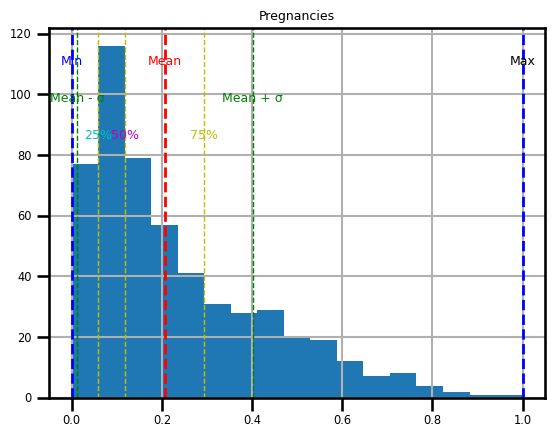

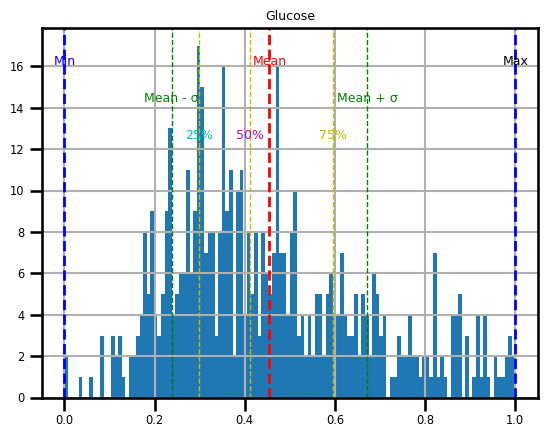

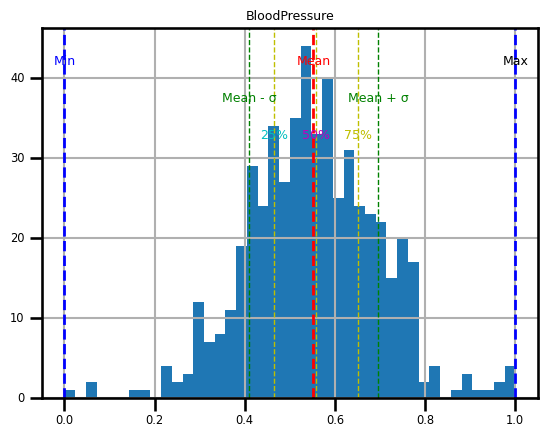

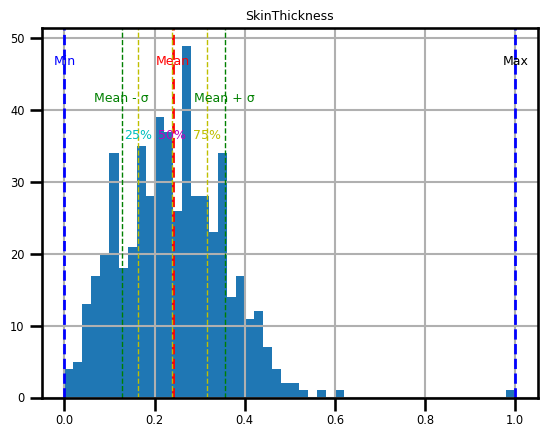

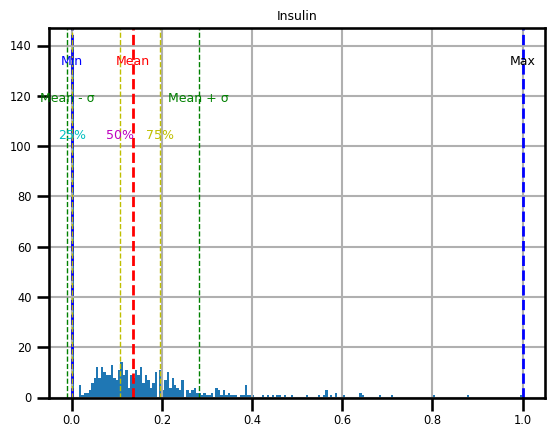

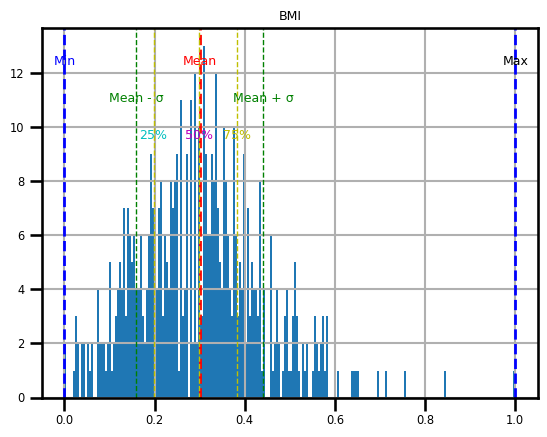

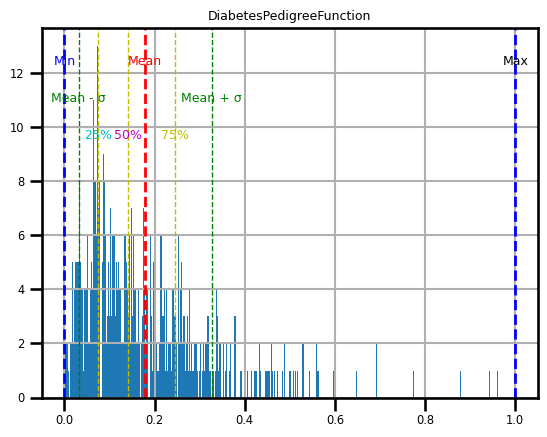

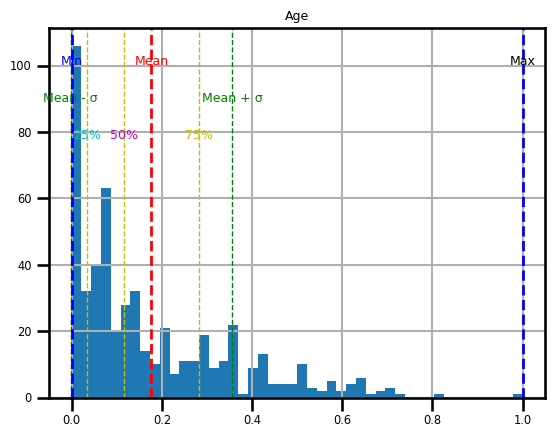

In [35]:
desc = data.describe()

for col in data.columns:
    if col == 'Outcome':
        continue
    plt.figure()
    data[col].hist(bins=len(data[col].unique()))
    
    mean = desc[col]['mean']
    std = desc[col]['std']
    min = desc[col]['min']
    q_25 = desc[col]['25%']
    median = desc[col]['50%']
    q_75 = desc[col]['75%']
    max = desc[col]['max']
    
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
    plt.text(mean, plt.ylim()[1]*0.9, 'Mean', color='r', ha='center')
    
    plt.axvline(mean + std, color='g', linestyle='dashed', linewidth=1)
    plt.text(mean + std, plt.ylim()[1]*0.8, 'Mean + σ', color='g', ha='center')
    
    plt.axvline(mean - std, color='g', linestyle='dashed', linewidth=1)
    plt.text(mean - std, plt.ylim()[1]*0.8, 'Mean - σ', color='g', ha='center')
    
    plt.axvline(min, color='b', linestyle='dashed', linewidth=2)
    plt.text(min, plt.ylim()[1]*0.9, 'Min', color='b', ha='center')
    
    plt.axvline(q_25, color='y', linestyle='dashed', linewidth=1)
    plt.text(q_25, plt.ylim()[1]*0.7, '25%', color='c', ha='center')
    
    plt.axvline(median, color='y', linestyle='dashed', linewidth=1)
    plt.text(median, plt.ylim()[1]*0.7, '50%', color='m', ha='center')
    
    plt.axvline(q_75, color='y', linestyle='dashed', linewidth=1)
    plt.text(q_75, plt.ylim()[1]*0.7, '75%', color='y', ha='center')
    
    plt.axvline(max, color='b', linestyle='dashed', linewidth=2)
    plt.text(max, plt.ylim()[1]*0.9, 'Max', color='k', ha='center')
    
    plt.title(col)
    plt.show()

## 3. Разделение данных на обучающую и тестовую выборки

In [36]:
def train_test_split(x, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(x))    
    test_size = int(len(x) * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

x = data.drop('Outcome', axis=1)
y = data['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 4. Логистическая регрессия
### 4.1. Определение функций

In [37]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, fit_intercept=True, threshold=0.5, optimization_method='gradient_descent'):
        self.theta = None
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
        self.threshold = threshold
        self.optimization_method = optimization_method
        
    def __add_intercept(self, x):
        intercept = np.ones((x.shape[0], 1))
        return np.concatenate((intercept, x), axis=1)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def log_loss(self, h, y):
        # Добавляем небольшое значение для предотвращения логарифма от 0
        eps = 1e-15
        h = np.clip(h, eps, 1 - eps)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit_gradient_descent(self, x, y):
        for i in range(self.num_iterations):
            z = np.dot(x, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(x.T, (h - y)) / y.size
            self.theta -= self.learning_rate * gradient
            
            if i % 100 == 0:
                loss = self.log_loss(h, y)
                print(f'Итерация {i}: loss {loss}')
                
    def fit_newton(self, x, y):
        for i in range(self.num_iterations):
            z = np.dot(x, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(x.T, (h - y)) / y.size
            # Гессиан 
            diag = h * (1 - h)
            H = np.dot(x.T, x * diag[:, np.newaxis]) / y.size
            
            # Обновление весов
            try:
                delta = np.linalg.inv(H).dot(gradient)
            except np.linalg.LinAlgError:
                print("Гессиан вырожден. Прекращаем обучение.")
                break
            
            self.theta -= delta
            
            if i % 100 == 0:
                loss = self.log_loss(h, y)
                print(f'Итерация {i}: loss {loss}')
                
    def fit(self, x, y):
        if self.fit_intercept:
            x = self.__add_intercept(x)
            
            # Инициализация весов нулями
            self.theta = np.zeros(x.shape[1])
            
            # В зависимости от метода оптимизации выбираем способ обучения
            if self.optimization_method == 'gradient_descent':
                self.fit_gradient_descent(x, y)
            elif self.optimization_method == 'newton':
                self.fit_newton(x, y)
            else:
                raise ValueError(f"Неизвестный метод оптимизации: {self.optimization_method}")
            
    def predict_prob(self, x):
        if self.fit_intercept:
            x = self.__add_intercept(x)
            
        return self.sigmoid(np.dot(x, self.theta))
    
    def predict(self, x):
        return self.predict_prob(x) >= self.threshold

## 5. Исследование гиперпараметров

In [38]:
import itertools

learning_rates = [1, 0.5, 0.1, 0.01, 0.001]
num_iterations = [10, 100, 1000, 10000]
optimization_methods = ['gradient_descent', 'newton']

parameter_combinations = list(itertools.product(learning_rates, num_iterations, optimization_methods))

## 6. Оценка модели

In [39]:
def calculate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    confusion_matrix = np.array([[TN, FP], [FN, TP]])
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-15)
    precision = TP / (TP + FP + 1e-15)
    recall = TP / (TP + FN + 1e-15)
    
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-15)
    
    return confusion_matrix, accuracy, precision, recall, f1_score

### 6.1. Исследование гиперпараметров

In [40]:
# Преобразуем данные в NumPy массивы
x_train_np = x_train.values
x_test_np = x_test.values
y_train_np = y_train.values
y_test_np = y_test.values

results = []

for lr, num_iter, method in parameter_combinations:
    print(f"Модель с параметрами: learning_rate={lr}, num_iterations={num_iter}, optimization_method={method}")
    model = LogisticRegression(learning_rate=lr, num_iterations=num_iter, threshold=0.5, optimization_method=method)
    model.fit(x_train_np, y_train_np)
    y_pred = model.predict(x_test_np).astype(int)
    
    # Вычисляем метрики
    cm, acc, prec, rec, f1 = calculate_metrics(y_test_np, y_pred)
    
    # Сохраняем результаты
    results.append({
        'optimization_method': method,
        'learning_rate': lr,
        'num_iterations': num_iter,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })
    
# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)
print(results_df)

Модель с параметрами: learning_rate=1, num_iterations=10, optimization_method=gradient_descent
Итерация 0: loss 0.6931471805599453
Модель с параметрами: learning_rate=1, num_iterations=10, optimization_method=newton
Итерация 0: loss 0.6931471805599453
Модель с параметрами: learning_rate=1, num_iterations=100, optimization_method=gradient_descent
Итерация 0: loss 0.6931471805599453
Модель с параметрами: learning_rate=1, num_iterations=100, optimization_method=newton
Итерация 0: loss 0.6931471805599453
Модель с параметрами: learning_rate=1, num_iterations=1000, optimization_method=gradient_descent
Итерация 0: loss 0.6931471805599453
Итерация 100: loss 0.502239302412423
Итерация 200: loss 0.47134379953987066
Итерация 300: loss 0.460458808403644
Итерация 400: loss 0.4553608044007313
Итерация 500: loss 0.4525883406026179
Итерация 600: loss 0.4509454523930166
Итерация 700: loss 0.4499184265100002
Итерация 800: loss 0.44925291359935837
Итерация 900: loss 0.44881042870140253
Модель с параметра

### 6.2. Визуализация результатов

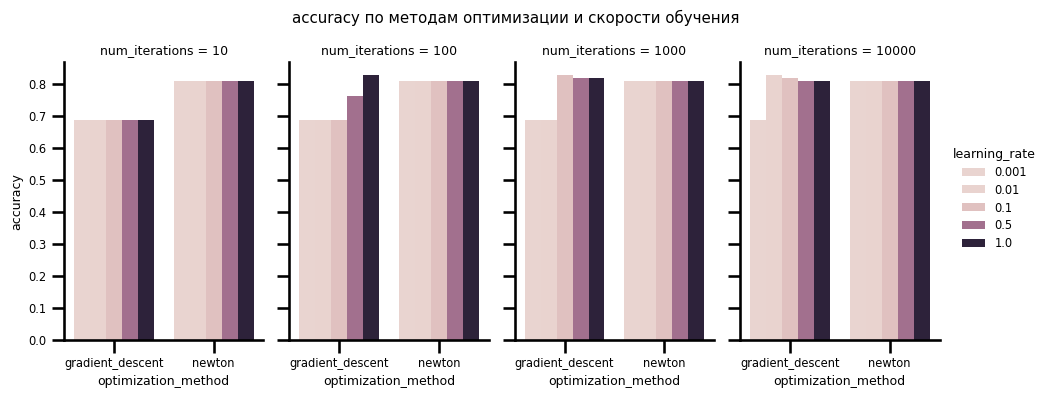

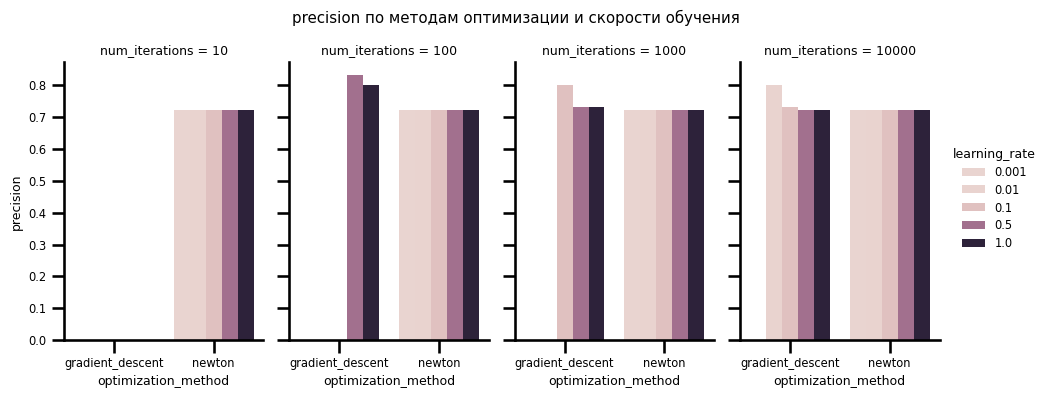

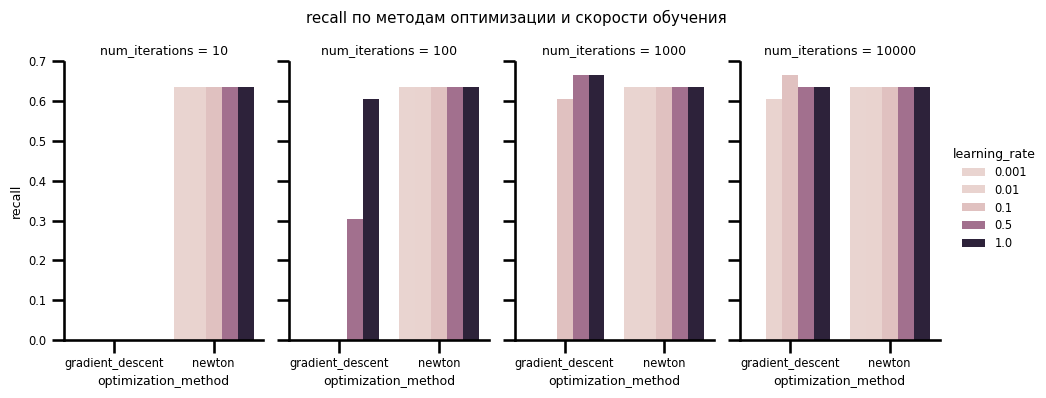

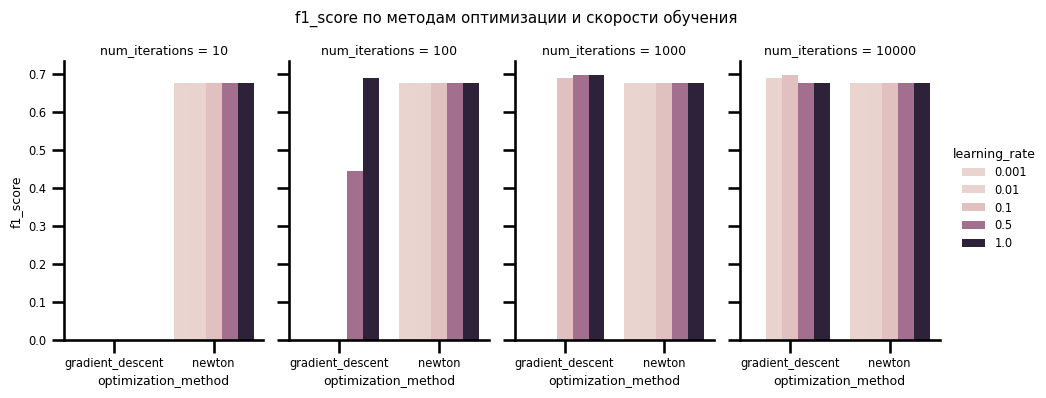

In [41]:
import seaborn as sns

sns.set_context("talk", font_scale=0.5)
sns.color_palette("bright")

params = ['accuracy', 'precision', 'recall', 'f1_score']

for param in params:
    g = sns.catplot(x='optimization_method', y=param, hue='learning_rate', col='num_iterations', data=results_df, kind='bar', height=4, aspect=0.6)
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{param} по методам оптимизации и скорости обучения")
    plt.show()

### 6.3. Лучшие параметры

In [42]:
# Функция для выбора лучшей модели на основе f1_socre и accuracy
def select_best_model(res):
    # Сначала сортируем по f1-Score, затем по accuracy
    sorted_df = res.sort_values(by=['f1_score', 'accuracy'], ascending=False)
    best = sorted_df.iloc[0]
    return best

# Выбираем лучшую модель
best_model = select_best_model(results_df)

# Печатаем информацию о лучшей модели
print("Лучшая модель:")
print(f"Метод оптимизации: {best_model['optimization_method']}")
print(f"Коэффициент обучения: {best_model['learning_rate']}")
print(f"Количество итераций: {best_model['num_iterations']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1-Score: {best_model['f1_score']:.4f}")

Лучшая модель:
Метод оптимизации: gradient_descent
Коэффициент обучения: 1.0
Количество итераций: 1000
Accuracy: 0.8208
Precision: 0.7333
Recall: 0.6667
F1-Score: 0.6984
